In [1]:
import pandas as pd
import numpy as np
import os
import scipy.stats as stats
# visualize
import seaborn as sns
import matplotlib.pyplot as plt

# turn off pink warning boxes
import warnings
warnings.filterwarnings("ignore")

#import my modules
import prepare
import acquire
import explore
import model_func as mf


# for preparation state
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

In [2]:
# *************************************  connection url **********************************************

# Create helper function to get the necessary connection url.
def get_connection(db_name):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    '''
    from env import host, username, password
    return f'mysql+pymysql://{username}:{password}@{host}/{db_name}'


In [3]:
# acquire data

In [4]:
#acquire data for the first time
def get_new_telco_churn():
    '''
    This function reads in the telco_churn data from the Codeup db
    and returns a pandas DataFrame with all columns and joined with other tables.
    '''
    sql_query = '''
    SELECT * FROM customers
    JOIN contract_types USING (contract_type_id)
    JOIN internet_service_types USING (internet_service_type_id)
    JOIN payment_types USING (payment_type_id)
    '''
    return pd.read_sql(sql_query, get_connection('telco_churn'))


In [5]:
#acquire data 
def get_telco_churn():
    '''
    This function reads in telco_churn data from Codeup database, writes data to
    a csv file if a local file does not exist, and returns a df.
    '''
    if os.path.isfile('telco_churn.csv'):
        
        # If csv file exists, read in data from csv file.
        df = pd.read_csv('telco_churn.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame.
        df = get_new_telco_churn()
        
        # Write DataFrame to a csv file.
        df.to_csv('telco_churn.csv')
        
    return df

In [6]:
#acquire data with my function
df= get_telco_churn()

In [7]:
# check the information before preparation process
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,...,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


In [8]:
df.shape

(7043, 24)

# preparation 

In [9]:
#check the type of the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [10]:
#checking the type of  the columns. I notice total_charges is an object type


In [11]:
#we cannot conver total_charges to float because there are ' '
#df['total_charges'].astype('float')

In [12]:
#take a look at these rows with space
df['total_charges'][df['total_charges']== ' ']

85       
156      
236      
255      
339      
5681     
5717     
5727     
5798     
6007     
6257     
Name: total_charges, dtype: object

In [13]:
#we will replace space with '0' for only these columns
df['total_charges'][df['total_charges']== ' ']= df['total_charges'][df['total_charges']== ' '].replace(' ', '0')

In [14]:
#checking if we replace it
df['total_charges'][df['total_charges']== ' ']

Series([], Name: total_charges, dtype: object)

In [15]:
#in order to conver total_charges to float, I need will add '0' to ' '
#df['total_charges'] = df['total_charges'] + '0'

In [16]:
#convert to a float type
df['total_charges'] = df['total_charges'].astype('float')
df['total_charges'].dtype

dtype('float64')

In [17]:
#checking nulls
df.isnull().sum()

payment_type_id             0
internet_service_type_id    0
contract_type_id            0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
internet_service_type       0
payment_type                0
dtype: int64

In [18]:
df.isna().sum()

payment_type_id             0
internet_service_type_id    0
contract_type_id            0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
internet_service_type       0
payment_type                0
dtype: int64

In [19]:
#checking for duplicates
df.duplicated().sum()

0

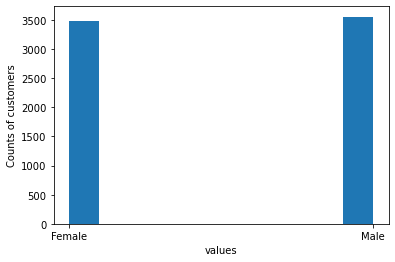

In [20]:
# individual variable distributions are plotted
plt.hist(df['gender'])
plt.xlabel('values')
plt.ylabel('Counts of customers')
plt.show()

In [21]:
# getting the columns name as a list
cols =df.columns.to_list()
cols

['payment_type_id',
 'internet_service_type_id',
 'contract_type_id',
 'customer_id',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'churn',
 'contract_type',
 'internet_service_type',
 'payment_type']

In [22]:
# plot each column, exclude the first 4 columns
cols[4:]

['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'churn',
 'contract_type',
 'internet_service_type',
 'payment_type']

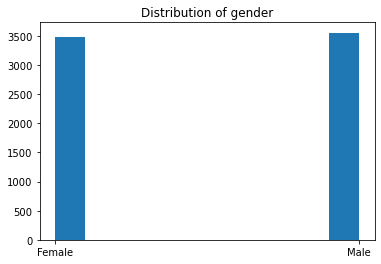

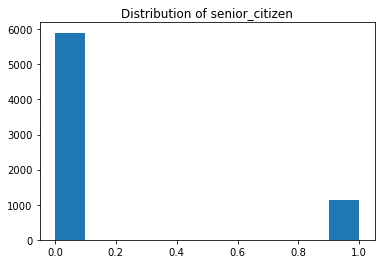

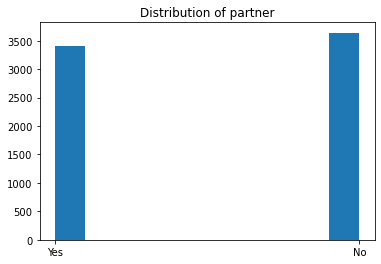

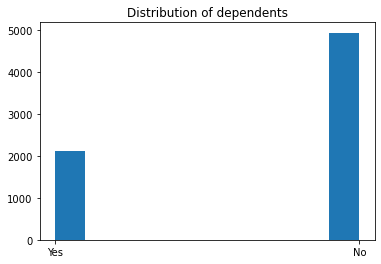

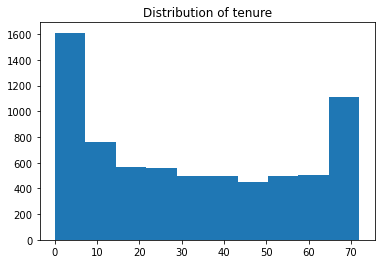

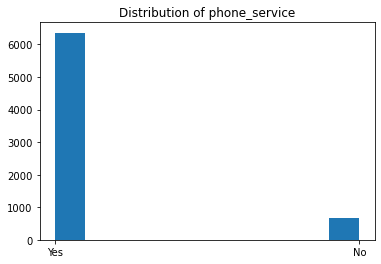

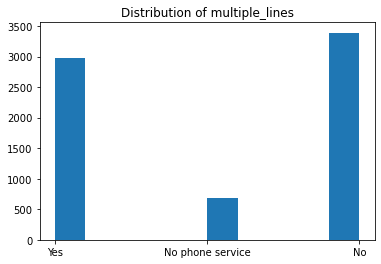

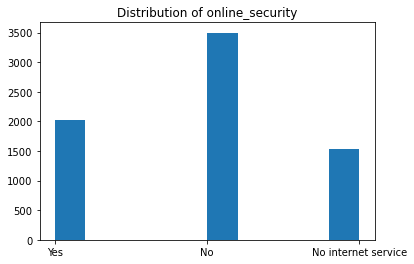

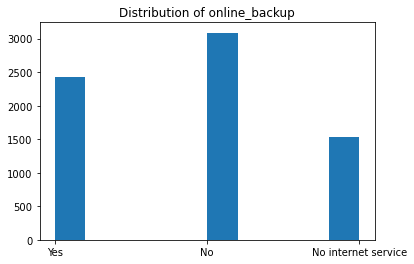

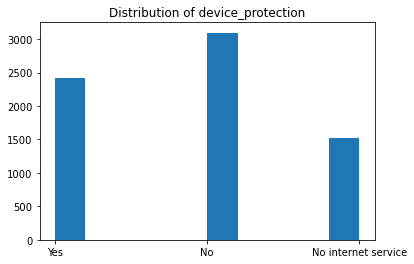

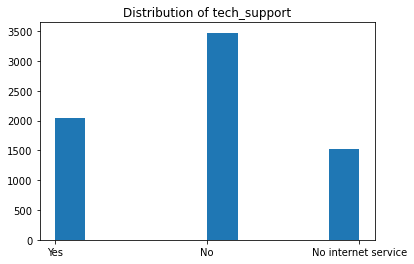

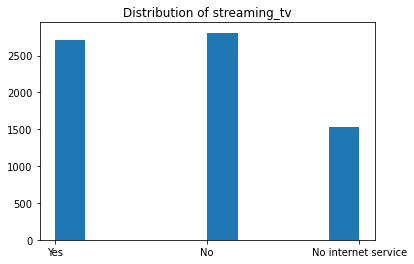

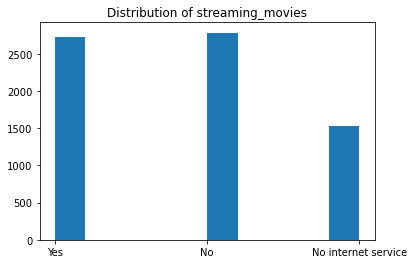

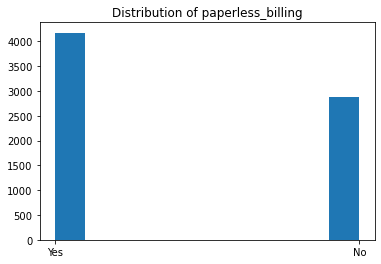

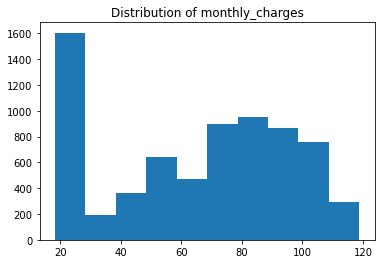

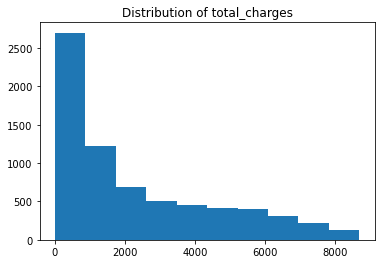

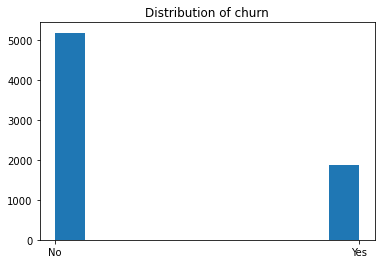

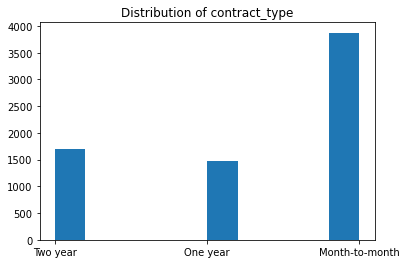

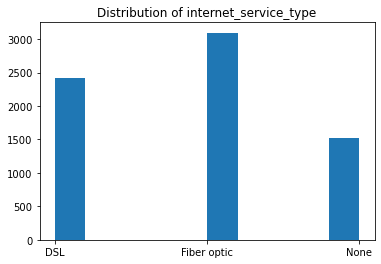

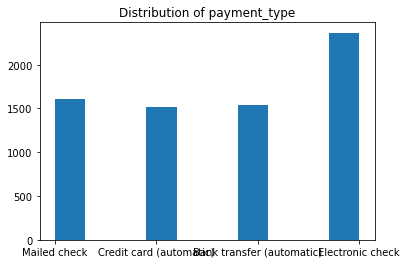

In [23]:
for col in cols[4:]:
    plt.hist(df[col])
    plt.title(f'Distribution of {col}')
    plt.show()

In [24]:
#make a function
def distribution (df):
    cols =df.columns.to_list()
    for col in cols[4:]:
        plt.hist(df[col])
        plt.title(f'Distribution of {col}')
        plt.show()

In [25]:
#checking again
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [26]:
#check the columns yes?no columns
df.head(1)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check


In [27]:
col =df.columns.to_list()
col

['payment_type_id',
 'internet_service_type_id',
 'contract_type_id',
 'customer_id',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'churn',
 'contract_type',
 'internet_service_type',
 'payment_type']

In [28]:
len(df['tenure'].value_counts())

73

In [29]:
df['gender'].value_counts().index[0]

'Male'

In [30]:
# getting all the columns with yes/no
col_2=[]
for c in col:
    if (len(df[c].value_counts())) == 2 and (df[c].value_counts().index[0] == 'Yes' or df[c].value_counts().index[0] == 'No' ):
        col_2.append(c)
    

In [31]:
col_2

['partner', 'dependents', 'phone_service', 'paperless_billing', 'churn']

In [32]:
#all the columns that have yes/no
col_2

['partner', 'dependents', 'phone_service', 'paperless_billing', 'churn']

In [33]:
#check all the values for these columns
for col in col_2:
    print(col)
    print(df[col].value_counts())
    print('__________________________')

partner
No     3641
Yes    3402
Name: partner, dtype: int64
__________________________
dependents
No     4933
Yes    2110
Name: dependents, dtype: int64
__________________________
phone_service
Yes    6361
No      682
Name: phone_service, dtype: int64
__________________________
paperless_billing
Yes    4171
No     2872
Name: paperless_billing, dtype: int64
__________________________
churn
No     5174
Yes    1869
Name: churn, dtype: int64
__________________________


In [34]:
#checking if we can change no/yes to 0/1 and compare above
(df.churn == 'Yes').astype(int).value_counts()

0    5174
1    1869
Name: churn, dtype: int64

In [35]:
#using this code we can change it
(df[col_2] == 'Yes').astype(int)

,partner,dependents,phone_service,paperless_billing,churn
0,1,1,1,1,0
1,0,0,0,0,0
2,0,0,0,0,0
3,1,1,0,1,0
4,1,0,1,1,0
...,...,...,...,...,...
7038,1,1,1,0,0
7039,0,0,1,0,0
7040,0,0,1,0,0
7041,0,0,1,0,0


In [36]:
# change the value no/yes to 0/1
df[col_2] = (df[col_2] == 'Yes').astype(int)

In [37]:
df[col_2].head()

,partner,dependents,phone_service,paperless_billing,churn
0,1,1,1,1,0
1,0,0,0,0,0
2,0,0,0,0,0
3,1,1,0,1,0
4,1,0,1,1,0


In [38]:
#check all the values for these columns to make sure it is correct
for col in col_2:
    print(col)
    print(df[col].value_counts(dropna = False))
    print('__________________________')

partner
0    3641
1    3402
Name: partner, dtype: int64
__________________________
dependents
0    4933
1    2110
Name: dependents, dtype: int64
__________________________
phone_service
1    6361
0     682
Name: phone_service, dtype: int64
__________________________
paperless_billing
1    4171
0    2872
Name: paperless_billing, dtype: int64
__________________________
churn
0    5174
1    1869
Name: churn, dtype: int64
__________________________


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   int64  
 7   dependents                7043 non-null   int64  
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   int64  
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [40]:
#selecting all the columns that are object type
df.select_dtypes('object').columns

Index(['customer_id', 'gender', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'contract_type', 'internet_service_type',
       'payment_type'],
      dtype='object')

In [41]:
#make a list of these type of columns , excluding 'customer_id'
list(df.select_dtypes('object').columns)[1:]

['gender',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'contract_type',
 'internet_service_type',
 'payment_type']

In [42]:
#checking the value of each columns
col_list = list(df.select_dtypes('object').columns)[1:]
for col in col_list:
    print(col)
    print(df[col].value_counts())
    print('__________________________')

gender
Male      3555
Female    3488
Name: gender, dtype: int64
__________________________
multiple_lines
No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64
__________________________
online_security
No                     3498
Yes                    2019
No internet service    1526
Name: online_security, dtype: int64
__________________________
online_backup
No                     3088
Yes                    2429
No internet service    1526
Name: online_backup, dtype: int64
__________________________
device_protection
No                     3095
Yes                    2422
No internet service    1526
Name: device_protection, dtype: int64
__________________________
tech_support
No                     3473
Yes                    2044
No internet service    1526
Name: tech_support, dtype: int64
__________________________
streaming_tv
No                     2810
Yes                    2707
No internet service    1526
Name: streamin

In [43]:
#the columns 'online_security','online_backup','device_protection','tech_support','streaming_tv','streaming_movies'
#have the same values 
col_list[2:8]

['online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies']

In [44]:
#create a dicttionary that have the values that we are going to change
var= {
    'No':0,
    'Yes':1,
    'No internet service':3
}

In [45]:
#using .map and for loop to change the values of each column on the list

In [46]:
for col in col_list[2:8]:
      df[col]= df[col].map(var) 


In [47]:
#check the changes
df[col_list[2:8]].head()

,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,1,1,1,1,1,1
1,1,0,0,1,1,0
2,1,1,1,1,0,0
3,1,0,1,1,0,0
4,0,1,1,1,1,1


In [48]:
#checking again the list of columns as 'object type'
df.select_dtypes('object').columns

Index(['customer_id', 'gender', 'multiple_lines', 'contract_type',
       'internet_service_type', 'payment_type'],
      dtype='object')

In [49]:
#I decide to convert this column to a values
df['multiple_lines'].unique()

array(['Yes', 'No phone service', 'No'], dtype=object)

In [50]:
#replace the values for numeric
df.replace({'multiple_lines': {'No':1, 'Yes':2, 'No phone service': 0}}, inplace=True)


In [51]:
df['multiple_lines'].unique()

array([2, 0, 1])

In [52]:
# make a list of the columns that are object type , exclude "customer_id"
col_list = list(df.select_dtypes('object').columns)[1:]

In [53]:
col_list

['gender', 'contract_type', 'internet_service_type', 'payment_type']

In [54]:
#create a dummy df of each column on the list
for col in col_list:
    dummy_df = pd.get_dummies(df[col], drop_first=True)
    df = pd.concat([df, dummy_df], axis=1)

In [55]:
# drop the columns that we already use to create dummy_df
df.drop(columns=col_list, inplace=True)

In [56]:
#check again the type of our columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   senior_citizen            7043 non-null   int64  
 5   partner                   7043 non-null   int64  
 6   dependents                7043 non-null   int64  
 7   tenure                    7043 non-null   int64  
 8   phone_service             7043 non-null   int64  
 9   multiple_lines            7043 non-null   int64  
 10  online_security           7043 non-null   int64  
 11  online_backup             7043 non-null   int64  
 12  device_protection         7043 non-null   int64  
 13  tech_support              7043 non-null   int64  
 14  streamin

In [57]:
#there is a column named None, that means no internet service. 
#0 = false (no internet service)
#1 = true (no internet service)

df['None'].value_counts()

0    5517
1    1526
Name: None, dtype: int64

In [58]:
# I will rename the column as has_internet
df.rename(columns={'None':'has_internet'}, inplace= True )

In [59]:
#checking the change
df['has_internet'].value_counts()

0    5517
1    1526
Name: has_internet, dtype: int64

In [60]:
#to match the values we want 
#0  = false (has internet)
#1 = true (has_internet)
df['has_internet'] = df['has_internet'].replace({0: 1, 1: 0})

In [61]:
df['has_internet'].value_counts()

1    5517
0    1526
Name: has_internet, dtype: int64

In [62]:
# rename 'tenure' so it can be more clear that the tenure is in months

df.rename(columns={'tenure':'tenure_months'}, inplace= True)

In [63]:
#creating my function

def clean_data(df):
    '''
    This function will drop payment_type_id', 'internet_service_type_id','contract_type_id', 
    convert all the columns that have yes/no to 0/1, 
    create dummy vars from 'gender', 'contract_type', 'internet_service_type', 'payment_type',
    change total_charges to a float type. 
    '''

    #clean data
    # conver total_charges to float
    df['total_charges'][df['total_charges']== ' ']= df['total_charges'][df['total_charges']== ' '].replace(' ', '0')
    df['total_charges'] = df['total_charges'].astype('float')
    
    #convert all the columns that have yes/no to 0/1
    col_list = ['partner', 'dependents','phone_service', 'paperless_billing','churn' ]
    df[col_list] = (df[col_list] == 'Yes').astype(int)
    
    #change columns to 0,1,2
    #getting a list of the  columns that I want to change
    col_list = list(df.select_dtypes('object').columns)[1:]
    #create a dicttionary to change the value
    var= {
        'No':0,
        'Yes':1,
        'No internet service':3
    }
    #use a for loop to change every column
    for col in col_list[2:8]:
        df[col]= df[col].map(var) 
    
    #replace the values of multiple_lines
    df.replace({'multiple_lines': {'No':1, 'Yes':2, 'No phone service': 0}}, inplace=True)
    
    #create a dummy df
    col_list = list(df.select_dtypes('object').columns)[1:]
    #create a dummy df
    for col in col_list:
        dummy_df = pd.get_dummies(df[col])
         ## Concatenate the dummy_df dataframe above with the original df
        df = pd.concat([df, dummy_df], axis=1)
    # drop the columns that we already use to create dummy_df
    df.drop(columns=col_list, inplace=True)
    
    #drop duplicates columns
    df.drop(columns = ['payment_type_id', 'internet_service_type_id','contract_type_id'], inplace=True)
    
    # rename 'tenure' so it can be more clear that the tenure is in months
    df.rename(columns={'tenure':'tenure_months'}, inplace= True)
    #  rename the column as has_internet
    df.rename(columns={'None':'has_internet'}, inplace= True )
    #changing the values to undestand better the meaning
    df['has_internet'] = df['has_internet'].replace({0: 1, 1: 0})
    # columns name change (remove space and -)
    df.columns = [col.lower().replace(' ', '_').replace('-','_') for col in df]
    df.columns
    return df


In [64]:
#acquire data
df = acquire.get_telco_churn()

In [65]:
df.shape

(7043, 24)

In [66]:
df.columns

Index(['payment_type_id', 'internet_service_type_id', 'contract_type_id',
       'customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'internet_service_type',
       'payment_type'],
      dtype='object')

In [67]:
#use my clean function
df_clean = prepare.clean_data(df)

In [68]:
df_clean.shape

(7043, 29)

In [69]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_id                7043 non-null   object 
 1   senior_citizen             7043 non-null   int64  
 2   partner                    7043 non-null   int64  
 3   dependents                 7043 non-null   int64  
 4   tenure_months              7043 non-null   int64  
 5   phone_service              7043 non-null   int64  
 6   multiple_lines             7043 non-null   int64  
 7   online_security            7043 non-null   int64  
 8   online_backup              7043 non-null   int64  
 9   device_protection          7043 non-null   int64  
 10  tech_support               7043 non-null   int64  
 11  streaming_tv               7043 non-null   int64  
 12  streaming_movies           7043 non-null   int64  
 13  paperless_billing          7043 non-null   int64

In [70]:
#calculate corr
df_corr = df_clean.corr()

In [71]:
df_corr

,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,...,month_to_month,one_year,two_year,dsl,fiber_optic,has_internet,bank_transfer_(automatic),credit_card_(automatic),electronic_check,mailed_check
senior_citizen,1.000000,0.016479,-0.211185,0.016567,0.008576,0.113791,-0.208709,-0.170002,-0.172926,-0.217566,...,0.138360,-0.046262,-0.117000,-0.108322,0.255338,0.182742,-0.016159,-0.024135,0.171718,-0.153477
partner,0.016479,1.000000,0.452676,0.379697,0.017706,0.117307,0.056157,0.059540,0.064584,0.047420,...,-0.280865,0.082783,0.248091,-0.000851,0.000304,-0.000615,0.110706,0.082029,-0.083852,-0.095125
dependents,-0.211185,0.452676,1.000000,0.159712,-0.001762,-0.019657,0.179614,0.161106,0.157003,0.173036,...,-0.231720,0.068368,0.204613,0.052010,-0.165818,-0.139812,0.052021,0.060267,-0.150642,0.059071
tenure_months,0.016567,0.379697,0.159712,1.000000,0.008448,0.258958,0.085500,0.107643,0.107656,0.084902,...,-0.645561,0.202570,0.558533,0.013274,0.019720,0.039062,0.243510,0.233006,-0.208363,-0.233852
phone_service,0.008576,0.017706,-0.001762,0.008448,1.000000,0.675070,0.146522,0.164540,0.156631,0.145215,...,-0.000742,-0.002791,0.003519,-0.452425,0.289999,-0.172209,0.007556,-0.007721,0.003062,-0.003319
multiple_lines,0.113791,0.117307,-0.019657,0.258958,0.675070,1.000000,-0.074857,-0.034674,-0.038667,-0.074777,...,-0.068119,-0.004199,0.083266,-0.361806,0.414749,0.082560,0.061513,0.042590,0.065663,-0.176117
online_security,-0.208709,0.056157,0.179614,0.085500,0.146522,-0.074857,1.000000,0.884432,0.883200,0.902492,...,-0.327446,0.079135,0.305769,-0.278888,-0.505673,-0.930746,0.034667,0.045975,-0.345600,0.309323
online_backup,-0.170002,0.059540,0.161106,0.107643,0.164540,-0.034674,0.884432,1.000000,0.879558,0.885567,...,-0.304844,0.075950,0.282497,-0.346101,-0.434998,-0.923087,0.033914,0.038887,-0.308409,0.275201
device_protection,-0.172926,0.064584,0.157003,0.107656,0.156631,-0.038667,0.883200,0.879558,1.000000,0.892017,...,-0.330240,0.083700,0.304677,-0.350834,-0.430560,-0.923197,0.032260,0.047479,-0.309516,0.269657
tech_support,-0.217566,0.047420,0.173036,0.084902,0.145215,-0.074777,0.902492,0.885567,0.892017,1.000000,...,-0.343202,0.077659,0.325508,-0.281927,-0.502320,-0.930210,0.037218,0.046797,-0.347130,0.307727


In [72]:
df_corr.shape

(28, 28)

In [73]:
# I just wat to see churn
df_corr['churn']

senior_citizen               0.150889
partner                     -0.150448
dependents                  -0.164221
tenure_months               -0.352229
phone_service                0.011942
multiple_lines               0.036310
online_security             -0.307989
online_backup               -0.280770
device_protection           -0.273951
tech_support                -0.306032
streaming_tv                -0.223123
streaming_movies            -0.224214
paperless_billing            0.191825
monthly_charges              0.193356
total_charges               -0.198324
churn                        1.000000
female                       0.008612
male                        -0.008612
month_to_month               0.405103
one_year                    -0.177820
two_year                    -0.302253
dsl                         -0.124214
fiber_optic                  0.308020
has_internet                 0.227890
bank_transfer_(automatic)   -0.117937
credit_card_(automatic)     -0.134302
electronic_c

In [74]:
df_corr['churn'].sort_values(ascending=False)

churn                        1.000000
month_to_month               0.405103
fiber_optic                  0.308020
electronic_check             0.301919
has_internet                 0.227890
monthly_charges              0.193356
paperless_billing            0.191825
senior_citizen               0.150889
multiple_lines               0.036310
phone_service                0.011942
female                       0.008612
male                        -0.008612
mailed_check                -0.091683
bank_transfer_(automatic)   -0.117937
dsl                         -0.124214
credit_card_(automatic)     -0.134302
partner                     -0.150448
dependents                  -0.164221
one_year                    -0.177820
total_charges               -0.198324
streaming_tv                -0.223123
streaming_movies            -0.224214
device_protection           -0.273951
online_backup               -0.280770
two_year                    -0.302253
tech_support                -0.306032
online_secur

In [75]:
df_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
senior_citizen,7043.0,0.162147,0.368612,0.00,0.00,0.00,0.00,1.00
partner,7043.0,0.483033,0.499748,0.00,0.00,0.00,1.00,1.00
dependents,7043.0,0.299588,0.458110,0.00,0.00,0.00,1.00,1.00
tenure_months,7043.0,32.371149,24.559481,0.00,9.00,29.00,55.00,72.00
phone_service,7043.0,0.903166,0.295752,0.00,1.00,1.00,1.00,1.00
multiple_lines,7043.0,1.325004,0.642730,0.00,1.00,1.00,2.00,2.00
online_security,7043.0,0.936675,1.165986,0.00,0.00,1.00,1.00,3.00
online_backup,7043.0,0.994889,1.142491,0.00,0.00,1.00,1.00,3.00
device_protection,7043.0,0.993895,1.142921,0.00,0.00,1.00,1.00,3.00
tech_support,7043.0,0.940224,1.164650,0.00,0.00,1.00,1.00,3.00


In [76]:
df_clean['female'].sum()

3488

In [77]:
df_clean['male'].sum()

3555

In [78]:
df_clean['senior_citizen'].sum()

1142

In [79]:
df_clean.columns

Index(['customer_id', 'senior_citizen', 'partner', 'dependents',
       'tenure_months', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'female', 'male', 'month_to_month',
       'one_year', 'two_year', 'dsl', 'fiber_optic', 'has_internet',
       'bank_transfer_(automatic)', 'credit_card_(automatic)',
       'electronic_check', 'mailed_check'],
      dtype='object')

In [80]:
df_clean

,customer_id,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,online_security,online_backup,device_protection,...,month_to_month,one_year,two_year,dsl,fiber_optic,has_internet,bank_transfer_(automatic),credit_card_(automatic),electronic_check,mailed_check
0,0016-QLJIS,0,1,1,65,1,2,1,1,1,...,0,0,1,1,0,1,0,0,0,1
1,0017-DINOC,0,0,0,54,0,0,1,0,0,...,0,0,1,1,0,1,0,1,0,0
2,0019-GFNTW,0,0,0,56,0,0,1,1,1,...,0,0,1,1,0,1,1,0,0,0
3,0056-EPFBG,0,1,1,20,0,0,1,0,1,...,0,0,1,1,0,1,0,1,0,0
4,0078-XZMHT,0,1,0,72,1,2,0,1,1,...,0,0,1,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9962-BFPDU,0,1,1,1,1,1,3,3,3,...,1,0,0,0,0,0,0,0,0,1
7039,9967-ATRFS,0,0,0,19,1,1,3,3,3,...,1,0,0,0,0,0,0,0,0,1
7040,9970-QBCDA,0,0,0,6,1,1,3,3,3,...,1,0,0,0,0,0,0,1,0,0
7041,9975-SKRNR,0,0,0,1,1,1,3,3,3,...,1,0,0,0,0,0,0,0,0,1


## Split

In [81]:
def split_data(df):
    '''
    take in a DataFrame and return train, validate, and test DataFrames; stratify on survived.
    return train, validate, test DataFrames.
    '''
    train_validate, test = train_test_split(df, test_size=.2, random_state=123, stratify=df.churn)
    train, validate = train_test_split(train_validate, 
                                       test_size=.3, 
                                       random_state=123, 
                                       stratify=train_validate.churn)
    return train, validate, test

In [82]:
train, validate, test = prepare.split_data(df_clean)

In [83]:
df_clean.shape

(7043, 29)

In [84]:
train.shape, validate.shape, test.shape

((3943, 29), (1691, 29), (1409, 29))

# Explore

In [85]:
#calculate corr
train_corr = train.corr()

In [86]:
train_corr

,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,...,month_to_month,one_year,two_year,dsl,fiber_optic,has_internet,bank_transfer_(automatic),credit_card_(automatic),electronic_check,mailed_check
senior_citizen,1.000000,0.021704,-0.201859,0.007666,0.017884,0.113170,-0.223637,-0.180790,-0.184644,-0.233621,...,0.157663,-0.051119,-0.134109,-0.120798,0.273674,0.191692,-0.015985,-0.012184,0.173069,-0.167323
partner,0.021704,1.000000,0.463617,0.366470,0.041129,0.138106,0.062610,0.063210,0.065330,0.045711,...,-0.268490,0.070877,0.243511,-0.010031,0.005104,-0.005469,0.094710,0.084683,-0.078225,-0.089288
dependents,-0.201859,0.463617,1.000000,0.160178,0.000945,-0.009975,0.190725,0.170296,0.163513,0.182896,...,-0.236495,0.062744,0.214199,0.049894,-0.167655,-0.145469,0.065442,0.056857,-0.163981,0.063927
tenure_months,0.007666,0.366470,0.160178,1.000000,0.006187,0.251475,0.072982,0.096895,0.091084,0.074255,...,-0.637509,0.198606,0.549839,0.020264,0.023973,0.052663,0.229637,0.241171,-0.215684,-0.222408
phone_service,0.017884,0.041129,0.000945,0.006187,1.000000,0.680810,0.144817,0.172211,0.157886,0.145593,...,0.004231,-0.005385,0.000155,-0.457254,0.295699,-0.172852,-0.002827,-0.006338,0.020748,-0.014355
multiple_lines,0.113170,0.138106,-0.009975,0.251475,0.680810,1.000000,-0.077098,-0.029548,-0.039713,-0.074705,...,-0.063852,-0.001498,0.075081,-0.375747,0.429184,0.083952,0.063351,0.039014,0.070523,-0.180946
online_security,-0.223637,0.062610,0.190725,0.072982,0.144817,-0.077098,1.000000,0.880648,0.880960,0.899994,...,-0.333326,0.099498,0.291552,-0.272998,-0.503865,-0.929045,0.035474,0.040707,-0.337960,0.305863
online_backup,-0.180790,0.063210,0.170296,0.096895,0.172211,-0.029548,0.880648,1.000000,0.876569,0.880710,...,-0.305250,0.092452,0.265745,-0.342592,-0.430394,-0.920802,0.035530,0.034741,-0.295689,0.263997
device_protection,-0.184644,0.065330,0.163513,0.091084,0.157886,-0.039713,0.880960,0.876569,1.000000,0.889550,...,-0.330609,0.098942,0.288936,-0.344440,-0.428472,-0.920618,0.036868,0.038843,-0.302230,0.266008
tech_support,-0.233621,0.045711,0.182896,0.074255,0.145593,-0.074705,0.899994,0.880710,0.889550,1.000000,...,-0.351141,0.101329,0.310396,-0.277070,-0.498879,-0.927728,0.042540,0.031986,-0.336475,0.305737


In [87]:
# I just want to see churn
train_corr['churn']

senior_citizen               0.165482
partner                     -0.137696
dependents                  -0.160315
tenure_months               -0.352282
phone_service                0.011995
multiple_lines               0.037585
online_security             -0.307907
online_backup               -0.275924
device_protection           -0.269440
tech_support                -0.307941
streaming_tv                -0.214859
streaming_movies            -0.219114
paperless_billing            0.187409
monthly_charges              0.189040
total_charges               -0.201972
churn                        1.000000
female                      -0.006885
male                         0.006885
month_to_month               0.409166
one_year                    -0.185215
two_year                    -0.298877
dsl                         -0.124500
fiber_optic                  0.303591
has_internet                 0.223698
bank_transfer_(automatic)   -0.116189
credit_card_(automatic)     -0.127042
electronic_c

In [88]:
#sort values
cols= train_corr['churn'].sort_values(ascending=False)
cols

churn                        1.000000
month_to_month               0.409166
fiber_optic                  0.303591
electronic_check             0.298034
has_internet                 0.223698
monthly_charges              0.189040
paperless_billing            0.187409
senior_citizen               0.165482
multiple_lines               0.037585
phone_service                0.011995
male                         0.006885
female                      -0.006885
mailed_check                -0.095605
bank_transfer_(automatic)   -0.116189
dsl                         -0.124500
credit_card_(automatic)     -0.127042
partner                     -0.137696
dependents                  -0.160315
one_year                    -0.185215
total_charges               -0.201972
streaming_tv                -0.214859
streaming_movies            -0.219114
device_protection           -0.269440
online_backup               -0.275924
two_year                    -0.298877
online_security             -0.307907
tech_support

<AxesSubplot:>

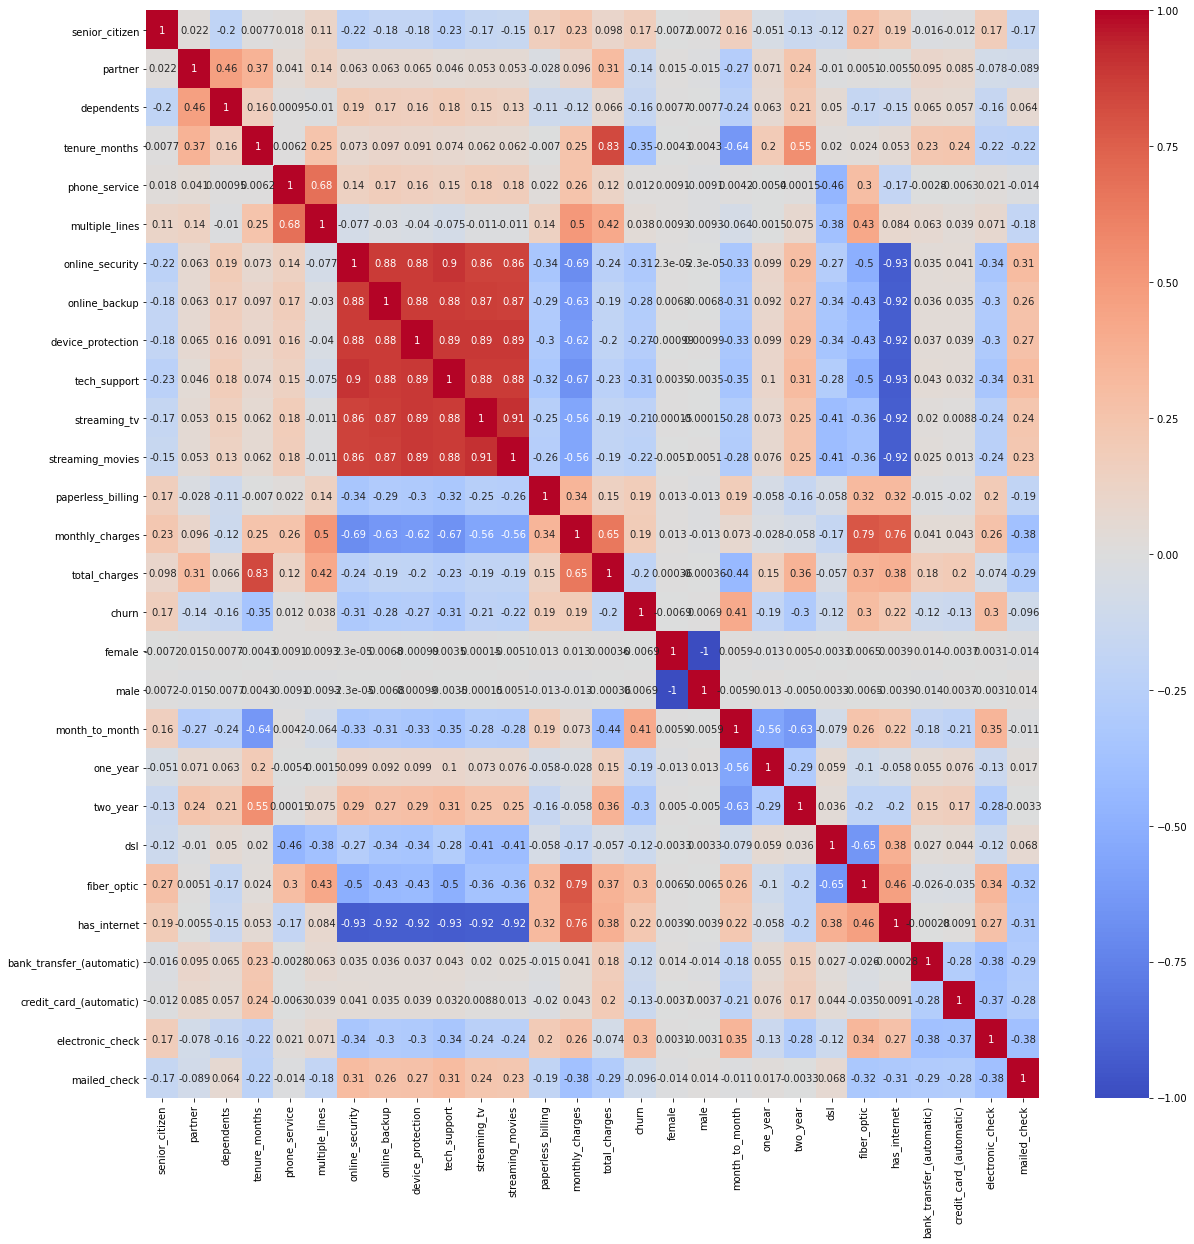

In [89]:
#check heat map but there is too much info
plt.figure(figsize=(20,20))
sns.heatmap(train.corr() , cmap='coolwarm', center=0, annot=True)

In [90]:
# I will select the columns to do the heat map again
list(cols[cols < (-.2)].index)


['total_charges',
 'streaming_tv',
 'streaming_movies',
 'device_protection',
 'online_backup',
 'two_year',
 'online_security',
 'tech_support',
 'tenure_months']

In [91]:
list(cols[cols > .18].index)

['churn',
 'month_to_month',
 'fiber_optic',
 'electronic_check',
 'has_internet',
 'monthly_charges',
 'paperless_billing']

In [92]:
#the final list to do the heat map again
col_listf = list(cols[cols > .18].index)  + list(cols[cols < (-.2)].index)
col_listf

['churn',
 'month_to_month',
 'fiber_optic',
 'electronic_check',
 'has_internet',
 'monthly_charges',
 'paperless_billing',
 'total_charges',
 'streaming_tv',
 'streaming_movies',
 'device_protection',
 'online_backup',
 'two_year',
 'online_security',
 'tech_support',
 'tenure_months']

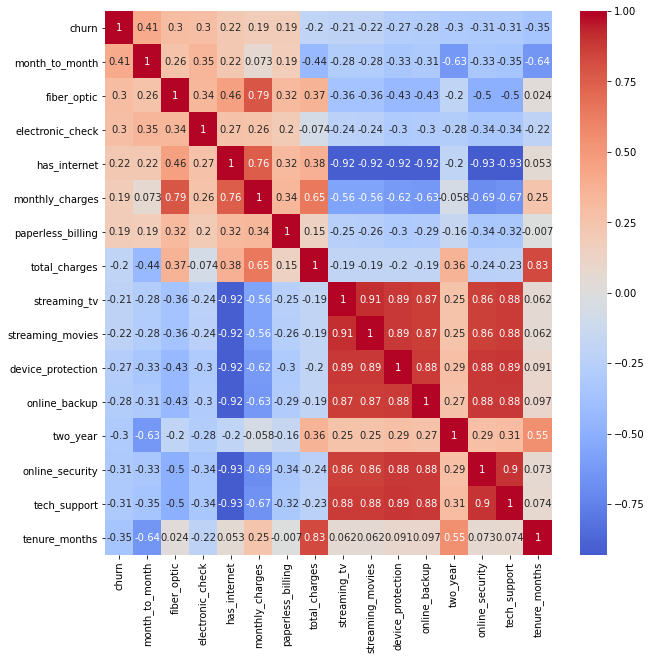

In [93]:
#
plt.figure(figsize=(10,10))
sns.heatmap(train[col_listf].corr() , cmap='coolwarm', center=0, annot=True)

plt.title('')
plt.show()

## Takeaways
churn has positive correlation:
- month_to_month contracts
- internet type : fiber_optic
- payment type: electronic check

churn has negative  correlation:
- tenure
- tech_suport
- online_security


In [94]:
# I was trying to narrow the list so I can use pailplot
col_list = list(cols[cols > .20].index)  + list(cols[cols < (-.27)].index)
col_list

['churn',
 'month_to_month',
 'fiber_optic',
 'electronic_check',
 'has_internet',
 'online_backup',
 'two_year',
 'online_security',
 'tech_support',
 'tenure_months']

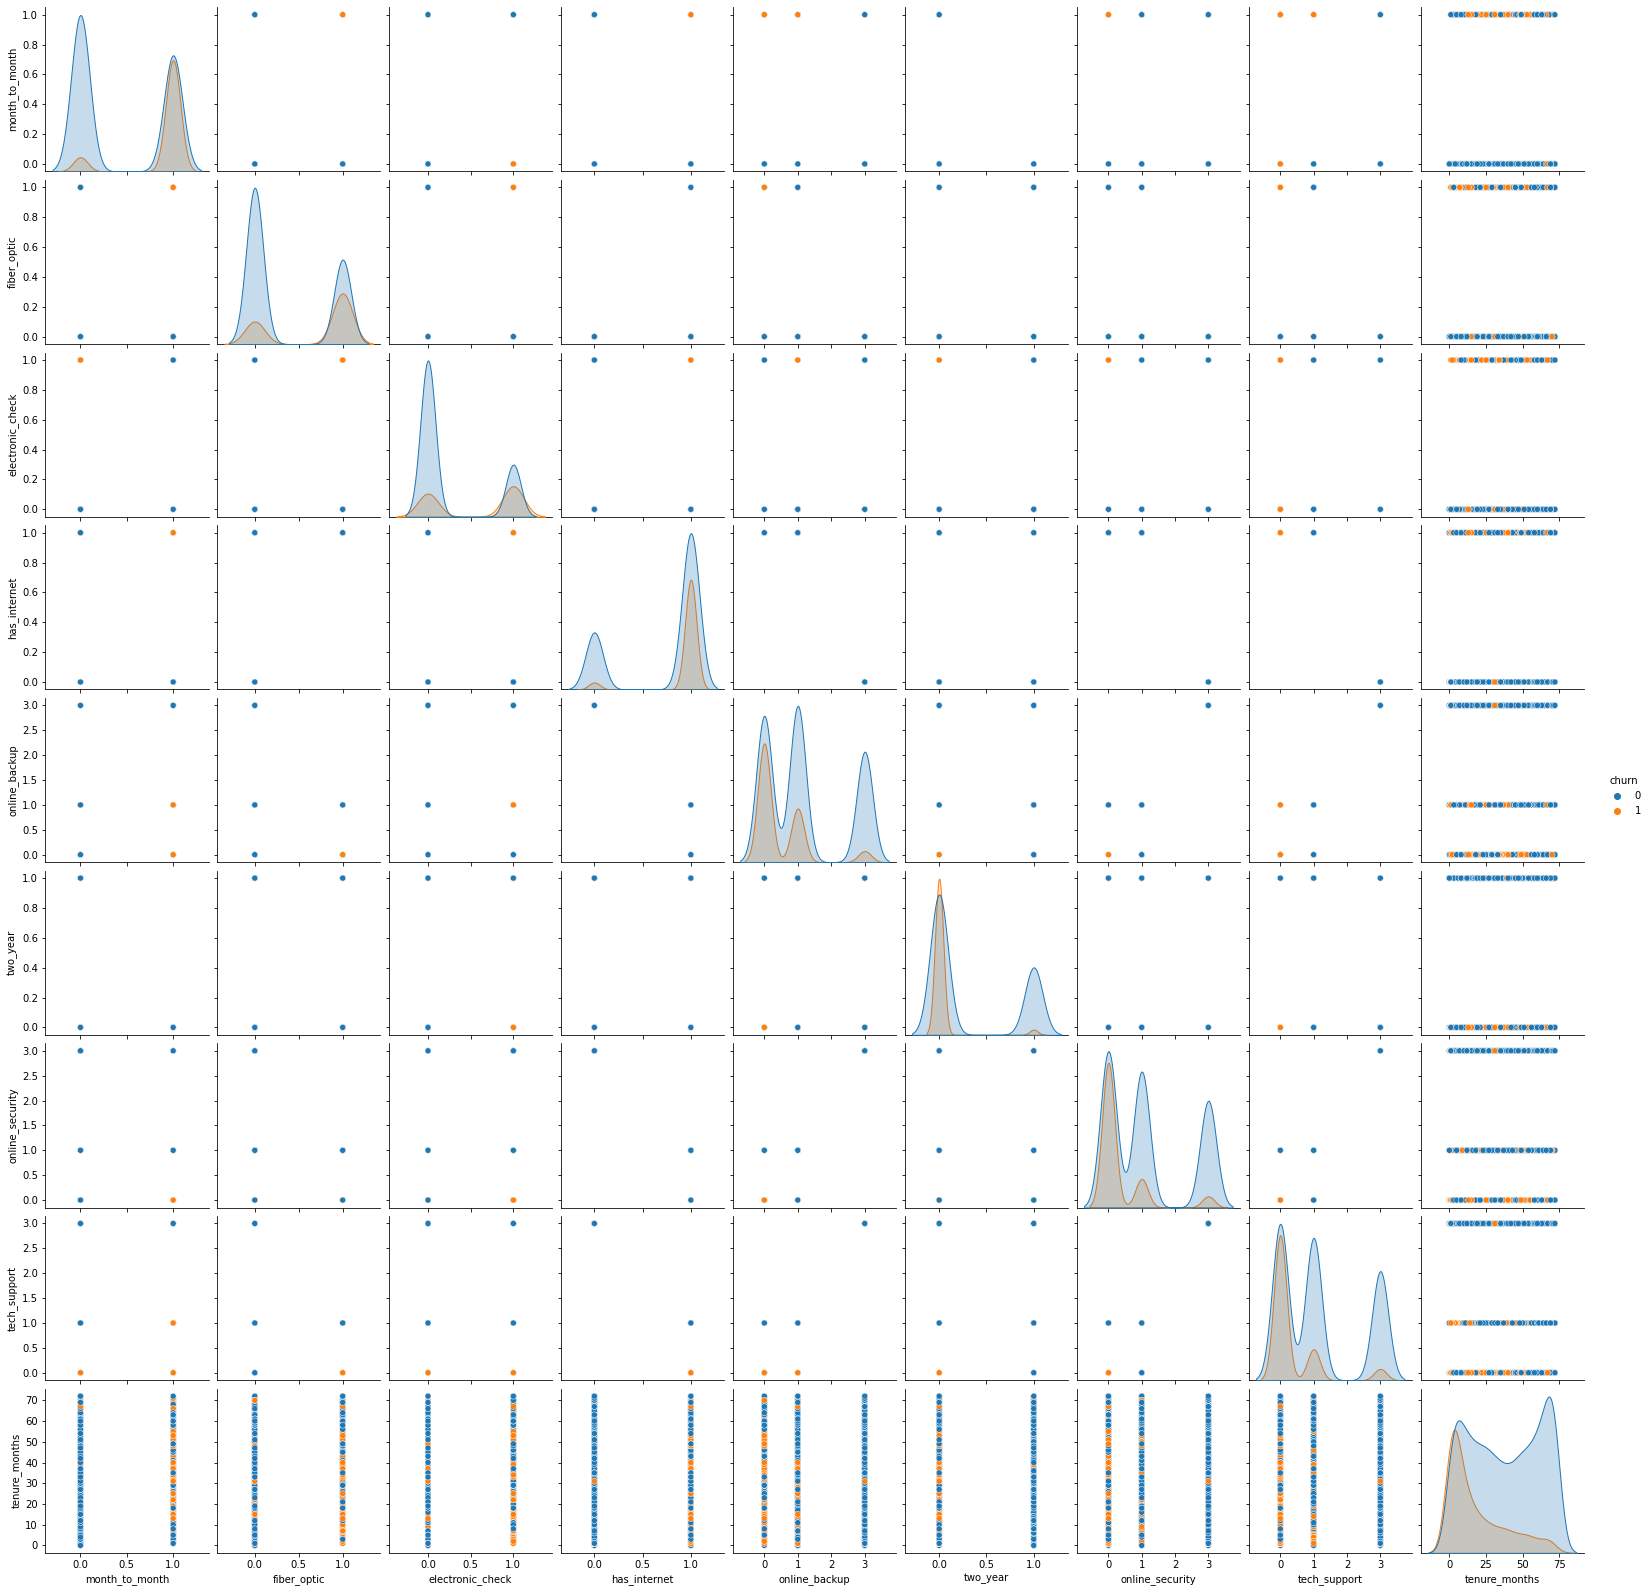

In [95]:
sns.pairplot(train[col_list], hue='churn')
plt.show()
## too much information 

In [96]:
# i willselect the 3 with positive & negative correlation 

In [97]:
#getting smaller my list
col_list = list(cols[cols > .25].index)  + list(cols[cols < (-.25)].index)
col_list

['churn',
 'month_to_month',
 'fiber_optic',
 'electronic_check',
 'device_protection',
 'online_backup',
 'two_year',
 'online_security',
 'tech_support',
 'tenure_months']

In [98]:
# let's see the churn rate
churn_rate = train['churn'].mean()
churn_rate

0.2652802434694395

In [99]:
train['churn'].value_counts()

0    2897
1    1046
Name: churn, dtype: int64

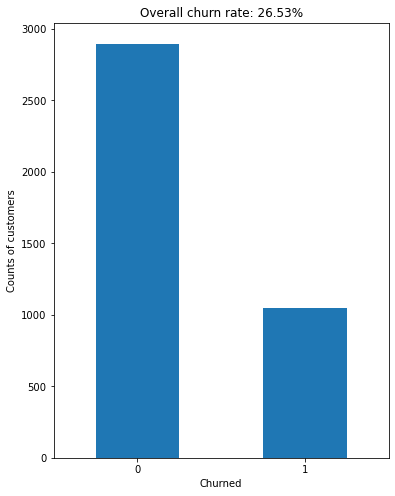

In [100]:
plt.figure(figsize=(6,8))
train.churn.value_counts().plot.bar(rot=0 )
plt.title(f"Overall churn rate: {churn_rate:.2%}")
plt.xlabel('Churned')
plt.ylabel('Counts of customers')

plt.show()

In [101]:
#let check tenure

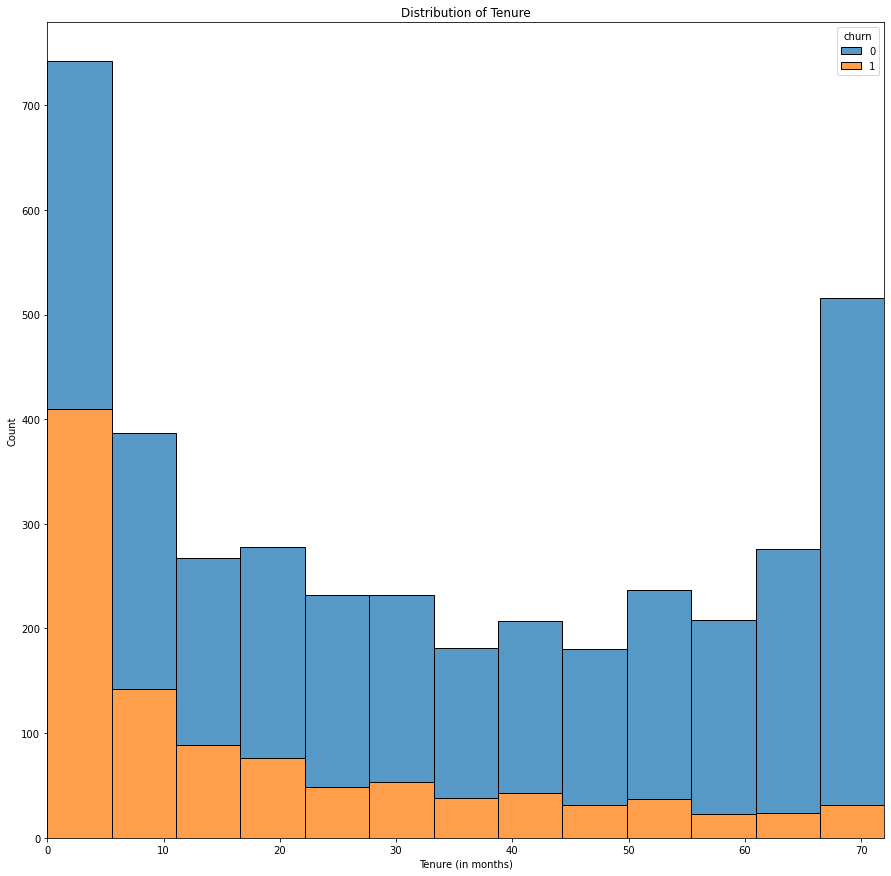

In [102]:
plt.figure(figsize=(15,15))
# Distribution of Tenure
sns.histplot(train,
             x=train.tenure_months,
             hue='churn',
             multiple='stack'
             )

plt.title("Distribution of Tenure")
plt.xlabel('Tenure (in months)')

plt.xlim(0, train.tenure_months.max());

(1.0, 29.0)

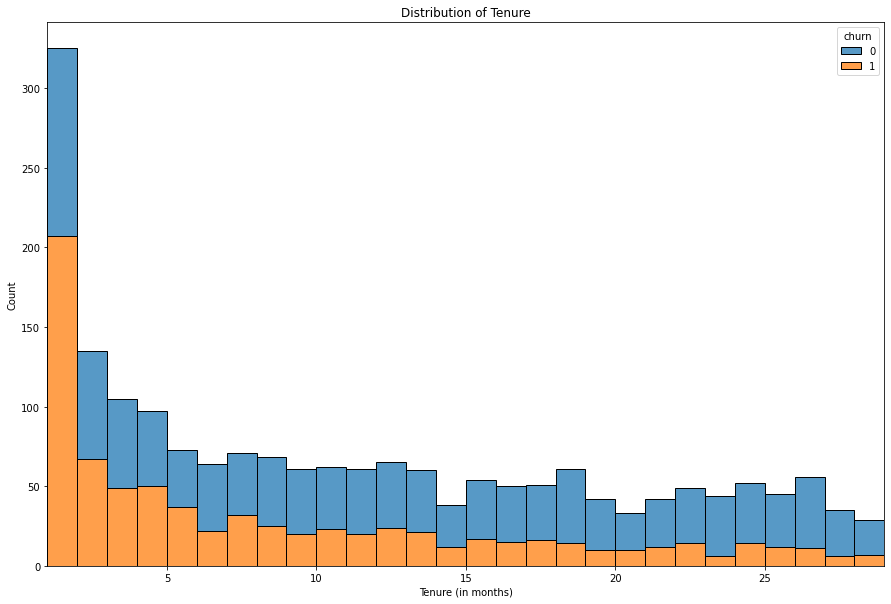

In [103]:
plt.figure(figsize=(15,10))
# Distribution of Tenure
sns.histplot(train,
             x=train.tenure_months,
             hue='churn',
             multiple='stack',
             binwidth=1          
             )

plt.title("Distribution of Tenure")
plt.xlabel('Tenure (in months)')
plt.xlim(1, train.tenure_months.median())

In [104]:
df.columns.to_list()

['payment_type_id',
 'internet_service_type_id',
 'contract_type_id',
 'customer_id',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'churn',
 'contract_type',
 'internet_service_type',
 'payment_type']

In [105]:
train[['monthly_charges','total_charges','tenure_months']][train['total_charges']== 0] # new customers

,monthly_charges,total_charges,tenure_months
339,80.85,0.0,0
6257,19.70,0.0,0
5681,20.00,0.0,0
85,56.05,0.0,0
156,61.90,0.0,0
236,73.35,0.0,0
255,52.55,0.0,0


In [106]:
train[['monthly_charges','total_charges','tenure_months']][train['tenure_months']== 1].head()

,monthly_charges,total_charges,tenure_months
4452,94.6,94.6,1
3796,74.6,74.6,1
1824,45.3,45.3,1
4159,74.4,74.4,1
4454,84.6,84.6,1


In [107]:
#total of customer tenure = 1
ct1 = train.tenure_months[train['tenure_months']== 1].count()
ct1

325

In [108]:
#customers tenure =1 and had canceled

In [109]:
df_t1 =train[['monthly_charges','tenure_months', 'churn','electronic_check','month_to_month','paperless_billing']][train['tenure_months']== 1]

In [110]:
can = df_t1.churn[ df_t1['churn'] == 1].count()
can

207

In [111]:
print(f"churn rate in the first month of Tenure: {(can/ct1):.2%}")

churn rate in the first month of Tenure: 63.69%


In [112]:
canc_df= pd.DataFrame((df_t1[(df_t1['churn']== 1) & (df_t1['month_to_month']== 1)].sum()),columns=['churn_counts'])
canc_df

,churn_counts
monthly_charges,12342.1
tenure_months,207.0
churn,207.0
electronic_check,120.0
month_to_month,207.0
paperless_billing,142.0


In [113]:
#customers with month_to month contracts and have canceled
m2m =(canc_df.loc['month_to_month'][0]).astype(int)
m2m

207

In [114]:
#customers with electronic_check and have canceled
ec=(canc_df.loc['electronic_check'][0]).astype(int)
ec

120

In [115]:
#customers with electronic_check and have canceled
ppl=(canc_df.loc['paperless_billing'][0]).astype(int)
ppl

142

In [116]:
print('** FIRST MONTH OF TENURE** ')
print(f'total customers :     {ct1} ')
print(f'total cancellations : {can} ')
print(f"churn rate in the first month of Tenure: {(can/ct1):.2%}")

** FIRST MONTH OF TENURE** 
total customers :     325 
total cancellations : 207 
churn rate in the first month of Tenure: 63.69%


In [117]:
print('** FIRST MONTH OF TENURE AND CHURN** ')
print(f'customers with month_to_month contracts: {(m2m/ct1):.2%} ')
print(f'customers with electronic_check contracts : {(ec/ct1):.2%} ')
print(f"customers with  paperless_billing: {(ppl/ct1):.2%}")

** FIRST MONTH OF TENURE AND CHURN** 
customers with month_to_month contracts: 63.69% 
customers with electronic_check contracts : 36.92% 
customers with  paperless_billing: 43.69%


TAKEAWAYS:
- cancelation is   63.69 % in the first month of tenure.  (they only made one payment)
- all the cancelation in the first month are month_to_month contracts
- customers who paid with electronic checks and canceled :36.92%
- customers with  paperless_billing and canceled: 43.69%
- new customer  0 tenure, 


****************


## create a function


In [118]:
train.head()

,customer_id,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,online_security,online_backup,device_protection,...,month_to_month,one_year,two_year,dsl,fiber_optic,has_internet,bank_transfer_(automatic),credit_card_(automatic),electronic_check,mailed_check
5642,1982-FEBTD,0,1,1,23,1,2,3,3,3,...,0,0,1,0,0,0,0,1,0,0
3338,8982-NHAVY,0,0,0,27,1,2,0,0,1,...,0,1,0,0,1,1,1,0,0,0
4273,4115-NZRKS,1,0,0,7,1,1,0,0,0,...,1,0,0,0,1,1,0,0,1,0
2382,9633-DENPU,0,1,0,47,1,1,0,1,0,...,1,0,0,1,0,1,1,0,0,0
2655,5693-PIPCS,0,0,0,41,1,1,0,1,0,...,0,0,1,0,1,1,0,1,0,0


In [119]:
#total of customer tenure = (tenure_less_than-1)
tenure_less_than =13

ct1 = train.tenure_months[train['tenure_months'] < tenure_less_than].count()
ct1

1194

In [120]:
#create a df with customers tenure = custom tenure
#cols has specific columsn the I want to see
cols = ['monthly_charges','month_to_month','one_year', 'two_year','has_internet','dsl','fiber_optic','multiple_lines','electronic_check','paperless_billing', 'tenure_months', 'churn']
df_t1 =train[cols][train['tenure_months'] < tenure_less_than ]
df_t1.head()

,monthly_charges,month_to_month,one_year,two_year,has_internet,dsl,fiber_optic,multiple_lines,electronic_check,paperless_billing,tenure_months,churn
4273,89.15,1,0,0,1,0,1,1,1,1,7,0
4452,94.60,1,0,0,1,0,1,2,1,1,1,1
4982,100.20,1,0,0,1,0,1,1,1,0,2,0
1340,25.05,1,0,0,1,1,0,0,0,0,7,0
4138,69.10,1,0,0,1,0,1,1,1,1,6,0


In [121]:
df_t1.shape

(1194, 12)

In [122]:
df_t1.drop(columns = ['dsl', 'fiber_optic','tenure_months','multiple_lines']).sum()

monthly_charges      67199.7
month_to_month        1079.0
one_year                67.0
two_year                48.0
has_internet           907.0
electronic_check       532.0
paperless_billing      708.0
churn                  576.0
dtype: float64

In [123]:
#total customer with tenure = custome tenure and churn =1
can = df_t1.churn[ df_t1['churn'] == 1].count()
can

576

In [124]:
#create a df and churn =1
churndf = df_t1[(df_t1['churn']== 1)]
churndf.head()

,monthly_charges,month_to_month,one_year,two_year,has_internet,dsl,fiber_optic,multiple_lines,electronic_check,paperless_billing,tenure_months,churn
4452,94.60,1,0,0,1,0,1,2,1,1,1,1
4606,94.60,1,0,0,1,0,1,2,1,1,3,1
1881,66.40,1,0,0,1,1,0,1,0,0,2,1
6749,19.65,1,0,0,0,0,0,1,1,0,8,1
3796,74.60,1,0,0,1,0,1,1,0,1,1,1


In [125]:
churndf.drop(columns = ['dsl', 'fiber_optic','dsl', 'fiber_optic','tenure_months','multiple_lines']).sum()

monthly_charges      38649.1
month_to_month         567.0
one_year                 9.0
two_year                 0.0
has_internet           524.0
electronic_check       333.0
paperless_billing      407.0
churn                  576.0
dtype: float64

In [126]:
#checking  the customers who have service phone
cols_m = ['multiple_lines','monthly_charges','dsl','fiber_optic', 'electronic_check', 'paperless_billing','month_to_month','one_year','two_year']
ml_df = churndf[cols_m].groupby( 'multiple_lines').sum()
ml_df

,monthly_charges,dsl,fiber_optic,electronic_check,paperless_billing,month_to_month,one_year,two_year
multiple_lines,,,,,,,,
0,1736.15,51.0,0.0,28.0,32,49.0,2.0,0.0
1,22068.75,97.0,202.0,189.0,228,343.0,7.0,0.0
2,14844.20,14.0,160.0,116.0,147,175.0,0.0,0.0


In [127]:
#calculate the total of phone service
phone = ml_df.iloc[1:3, 5:].sum().sum()
phone

525.0

In [128]:
#calculate tonly internet service
only_int = (ml_df.iloc[0, 1:3].sum()).astype(int)

In [129]:
#create a df churn = 1 and tenure < tenure
cols_1v = ['monthly_charges','electronic_check','paperless_billing','month_to_month', 'one_year','two_year','churn']
res_df= pd.DataFrame((churndf[cols_1v].sum()),columns=['churn_counts'])
res_df

,churn_counts
monthly_charges,38649.1
electronic_check,333.0
paperless_billing,407.0
month_to_month,567.0
one_year,9.0
two_year,0.0
churn,576.0


In [130]:
#calculate nmontlhy charges
m_char = res_df.iloc[0, 0]

In [131]:
# let's see the churn rate
churn_rate = train['churn'].mean()


In [132]:
print(f'** THE FIRST {tenure_less_than -1}  MONTH(S) OF TENURE ** ')
print(f'total customers :     {ct1} ')
print(f'total cancellations : {can} ')
print(f"Churn rate in the first {tenure_less_than -1} of Tenure: {(can/ct1):.2%}")
print("")
print("")
print (f"****Overall churn rate: {churn_rate:.2%}******")

** THE FIRST 12  MONTH(S) OF TENURE ** 
total customers :     1194 
total cancellations : 576 
Churn rate in the first 12 of Tenure: 48.24%


****Overall churn rate: 26.53%******


In [133]:
print("")
print("")
print(f'** FIRST {tenure_less_than -1} MONTHS OF TENURE AND CHURN** ')
print("")
print(f'Customers with phone service:         {(phone/can):.2%} ')
print(f'Customers with only internet service: {(only_int/can):.2%} ')
print(f'Monlthy charges: $ {m_char} ')
print("")
print("")



** FIRST 12 MONTHS OF TENURE AND CHURN** 

Customers with phone service:         91.15% 
Customers with only internet service: 8.85% 
Monlthy charges: $ 38649.100000000006 




In [134]:
#customers with month_to month contracts and have canceled
m2m =(res_df.loc['month_to_month'][0]).astype(int)


In [135]:
#customers with mone year contract and churn
oyc =(res_df.loc['one_year'][0]).astype(int)


In [136]:
#customers with two year contract and churn
tyc =(res_df.loc['two_year'][0]).astype(int)


In [137]:
#customers with electronic_check and have canceled
ec=(res_df.loc['electronic_check'][0]).astype(int)
ec

333

In [138]:
#customers with paperless billing and have canceled
ppl=(res_df.loc['paperless_billing'][0]).astype(int)
ppl

407

In [139]:
print(f'** FIRST {tenure_less_than -1} MONTHS OF TENURE AND CHURN** ')
print("")
print(f'Month_to_month contracts: {(m2m/can):.2%} ')
print(f'One year contract: {(oyc/can):.2%} ')
print(f'Two year contract: {(tyc/can):.2%} ')
print(f'Electronic_check payment type : {(ec/can):.2%} ')
print(f"Paperless_billing: {(ppl/can):.2%}")

** FIRST 12 MONTHS OF TENURE AND CHURN** 

Month_to_month contracts: 98.44% 
One year contract: 1.56% 
Two year contract: 0.00% 
Electronic_check payment type : 57.81% 
Paperless_billing: 70.66%


In [140]:
def report_tenure (df, tenure):
    '''
    This function create a report based on a specified tenure. Calculate total customers, churn customers, churn rate,
    % of phone service , % only internet,  % of type of contracts, and electronic cheks and paperless billing for
    the first months of the specified tenure, 
    df: dataframe
    tenure : number of the first month of tenure.
    Example:
    report_tenure (df, tenure)
    
    '''
    #add 1 so the numer given is included in the condiction ['tenure_months'] < tenure
    tenure=tenure+ 1
    #cols has all the columns that I want to check
    cols = ['monthly_charges','month_to_month','one_year', 'two_year','has_internet','dsl','fiber_optic','multiple_lines','electronic_check','paperless_billing', 'tenure_months', 'churn']
    #create a df with the fist months of tenure specified in the function
    df_t1 =train[cols][train['tenure_months'] < tenure ]
    #total of customers that have the specified tenure
    ct1 = train.tenure_months[train['tenure_months'] < tenure].count()
    #total customer with specified tenure and churn =1
    can = df_t1.churn[ df_t1['churn'] == 1].count()
    #create a df and churn =1
    churndf = df_t1[(df_t1['churn']== 1)]
    #df of customers who have service phone
    cols_m = ['multiple_lines','monthly_charges','dsl','fiber_optic', 'electronic_check', 'paperless_billing','month_to_month','one_year','two_year']
    ml_df = churndf[cols_m].groupby( 'multiple_lines').sum()
    #calculate the total of phone service
    phone = ml_df.iloc[1:3, 5:].sum().sum()
    #calculate tonly internet service
    only_int = (ml_df.iloc[0, 1:3].sum()).astype(int)
    #create report of  churn = 1 and tenure < tenure
    cols_1v = ['monthly_charges','electronic_check','paperless_billing','month_to_month', 'one_year','two_year','churn']
    res_df= pd.DataFrame((churndf[cols_1v].sum()),columns=['churn_counts'])
    #calculate nmontlhy charges
    m_char = res_df.iloc[0, 0]
    # let's see the churn rate
    churn_rate = train['churn'].mean()
    #customers with month_to month contracts and have canceled
    m2m =(res_df.loc['month_to_month'][0]).astype(int)
    #customers with mone year contract and churn
    oyc =(res_df.loc['one_year'][0]).astype(int)
    #customers with two year contract and churn
    tyc =(res_df.loc['two_year'][0]).astype(int)
    #customers with electronic_check and have canceled
    ec=(res_df.loc['electronic_check'][0]).astype(int)
    #customers with paperless billing and have canceled
    ppl=(res_df.loc['paperless_billing'][0]).astype(int)
    print(f'                      *** THE FIRST {tenure -1}  MONTH(S) OF TENURE *** ')
    print("")
    print(f'Total customers :     {ct1} ')
    print(f'Total cancellations : {can} ')
    print(f"Churn rate in the first {tenure -1 } of Tenure: {(can/ct1):.2%}")
    print("")
    print (f"****Overall churn rate: {churn_rate:.2%}******")
    print("")
    print("________________________________________________________________________________")
    print("")
    print(f'                    ** FIRST {tenure-1} MONTH(S) OF TENURE AND CHURN** ')
    print("")
    print(f'Customers with phone service:         {(phone/can):.2%} ')
    print(f'Customers with only internet service: {(only_int/can):.2%} ')
    print(f'Monlthy charges: $ {str(round(m_char, 3))} ')
    print("")

    print("")
    print(f'Month_to_month contracts: {(m2m/can):.2%} ')
    print(f'One year contract:        {(oyc/can):.2%} ')
    print(f'Two year contract:        {(tyc/can):.2%} ')
    print(f"Paperless_billing:        {(ppl/can):.2%}")
    print(f'Electronic_check payment type : {(ec/can):.2%} ')


In [141]:
report_tenure (train, 2)

                      *** THE FIRST 2  MONTH(S) OF TENURE *** 

Total customers :     467 
Total cancellations : 274 
Churn rate in the first 2 of Tenure: 58.67%

****Overall churn rate: 26.53%******

________________________________________________________________________________

                    ** FIRST 2 MONTH(S) OF TENURE AND CHURN** 

Customers with phone service:         91.97% 
Customers with only internet service: 8.03% 
Monlthy charges: $ 16818.9 


Month_to_month contracts: 99.64% 
One year contract:        0.36% 
Two year contract:        0.00% 
Paperless_billing:        68.25%
Electronic_check payment type : 58.39% 


***************************

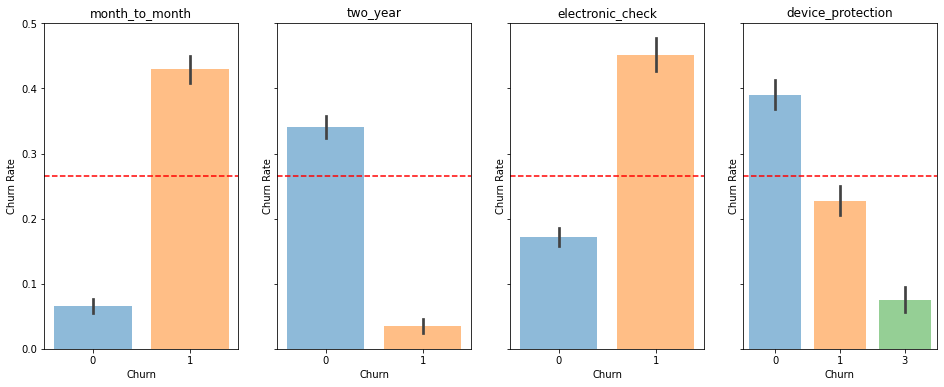

In [142]:
features = ['month_to_month', 'two_year', 'electronic_check','device_protection']


_, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn', data=train, ax=ax[i], alpha=0.5, saturation=1)
    ax[i].set_xlabel('Churn')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='red')

Takeaways:
- month to month contracts have a significant higher churn rate
- two_year contracts have low churn rate
- customer who used electronic_check have a higher churn rate. this is not an autopay. ** we canc check the churn rate of the customerwith month_to_month contract an el;ectronic_check
- customers that have device protection tend to stay.


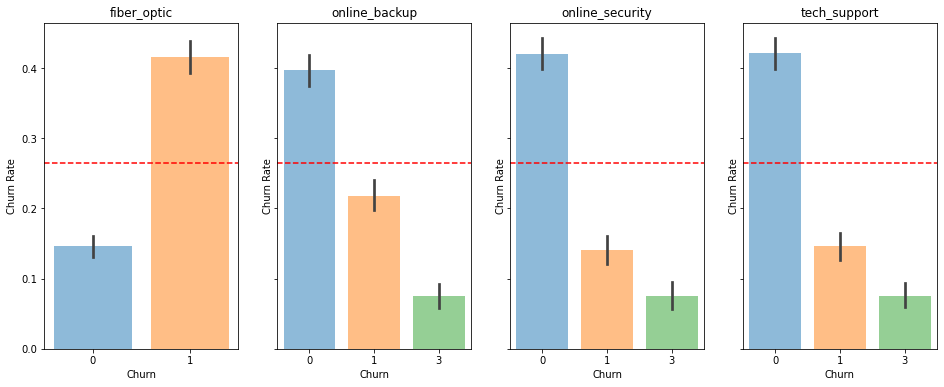

In [143]:
features = ['fiber_optic', 'online_backup', 'online_security','tech_support']


_, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn', data=train, ax=ax[i], alpha=0.5, saturation =1)
    ax[i].set_xlabel('Churn')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='red')

Takeaways
- customer that have the type of internet as fiber optic have a higher churn rate. we need to check the fiber optic service to see why the customer are leaving, if it is a problem with the service ? speed?  because we dont want to change our customersto dsl service 
-customer who have online_backup, online_security, tech_suppor have a lower churn of rate

In [144]:
train.columns

Index(['customer_id', 'senior_citizen', 'partner', 'dependents',
       'tenure_months', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'female', 'male', 'month_to_month',
       'one_year', 'two_year', 'dsl', 'fiber_optic', 'has_internet',
       'bank_transfer_(automatic)', 'credit_card_(automatic)',
       'electronic_check', 'mailed_check'],
      dtype='object')

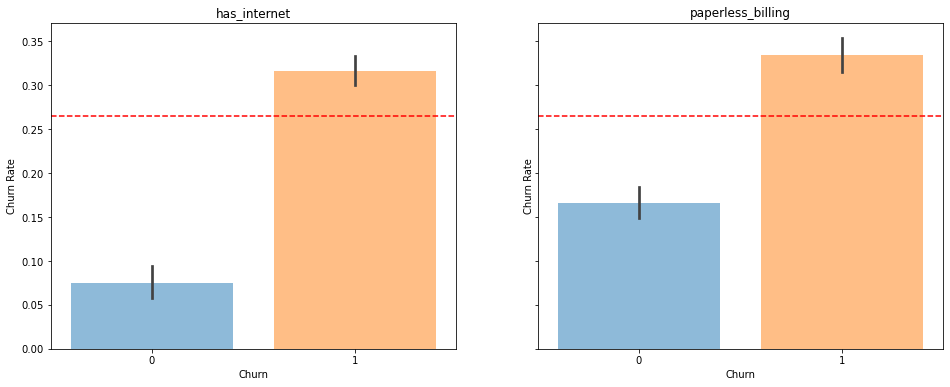

In [145]:
features = ['has_internet',  'paperless_billing']


_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn', data=train, ax=ax[i], alpha=0.5, saturation =1)
    ax[i].set_xlabel('Churn')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='red')

takeaways:
- customers with paperless_billing have a higher churn rate. we can offer all teh clients to suscribe to paperless to suscribe autopay at the same time with a discount.
- cutomer with internet have higher churn rste. (this also is the same as fiber_optic) here we can check if the mayority of customer have fiber_optic
    

#  statistical tests

churn is cat 


**Tenure**  = cont

cont vs cat =  t_test


- $H_o$: There is no difference between churn and tenure
- $H_a$: There is a  difference between churn and tenure

Significance level $\alpha$ = 0.05

In [146]:
alpha = 0.5
t, p = stats.ttest_1samp(train.tenure_months, train.churn.mean())

In [147]:
t,p

(83.15502839215699, 0.0)

In [148]:

if (p < alpha):
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


Text(0, 0.5, 'churn')

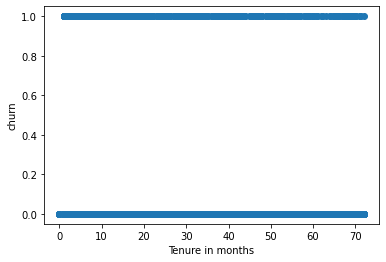

In [149]:

x = train['tenure_months']
y = train['churn']
plt.scatter(x,y)
plt.xlabel('Tenure in months')
plt.ylabel('churn')

**Fiber Optic** cat vs cat  = chi square


- $H_o$: Rate of churn is not dependent on Fiber Optic .
- $H_a$: Rate of churn is dependent on Fiber Optic status.


Significance level $\alpha$ = 0.05

In [150]:
observed = pd.crosstab(train.fiber_optic, train.churn)
observed

churn,0,1
fiber_optic,,
0,1881,322
1,1016,724


In [151]:
chi2, p, degf, expected =stats.chi2_contingency(observed)

In [152]:
print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[1881  322]
 [1016  724]]
---
Expected

[[1618  584]
 [1278  461]]
---

chi^2 = 362.0332
p     = 0.0000


In [153]:
if p < alpha:
    print('We reject the null Hypothesis')
else:
    print("we fail to reject the null")

We reject the null Hypothesis


**Electronic Check**  cat vs cat  = chi square

- $H_o$: Rate of churn is not dependent on using electronic check as the form of payment.
- $H_a$: Rate of churn is dependent on using electronic check as the form of payment.

Significance level  𝛼  = 0.05

In [154]:
observed2 = pd.crosstab(train.electronic_check, train.churn)
observed2

churn,0,1
electronic_check,,
0,2172,451
1,725,595


In [155]:
chi2, p, degf, expected =stats.chi2_contingency(observed2)

In [156]:
print('Observed\n')
print(observed2.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[2172  451]
 [ 725  595]]
---
Expected

[[1927  695]
 [ 969  350]]
---

chi^2 = 348.8043
p     = 0.0000


In [157]:
if p < alpha:
    print('We reject the null Hypothesis')
else:
    print("we fail to reject the null")

We reject the null Hypothesis


# MODEL

**Baseline** the most frequen value churn

In [158]:
#get the most frequen value.  0 = no churn
train.churn.value_counts().nlargest(1)

0    2897
Name: churn, dtype: int64

In [159]:
train['baseline']= 0

In [160]:
train.head()

,customer_id,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,online_security,online_backup,device_protection,...,one_year,two_year,dsl,fiber_optic,has_internet,bank_transfer_(automatic),credit_card_(automatic),electronic_check,mailed_check,baseline
5642,1982-FEBTD,0,1,1,23,1,2,3,3,3,...,0,1,0,0,0,0,1,0,0,0
3338,8982-NHAVY,0,0,0,27,1,2,0,0,1,...,1,0,0,1,1,1,0,0,0,0
4273,4115-NZRKS,1,0,0,7,1,1,0,0,0,...,0,0,0,1,1,0,0,1,0,0
2382,9633-DENPU,0,1,0,47,1,1,0,1,0,...,0,0,1,0,1,1,0,0,0,0
2655,5693-PIPCS,0,0,0,41,1,1,0,1,0,...,0,1,0,1,1,0,1,0,0,0


In [161]:
#accuracy
baseline_acc =(train.baseline == train.churn).mean()
baseline_acc

0.7347197565305605

In [162]:

print(f'The baseline accuracy for No Churn in all cases on the telco Dataset is {(train.baseline == train.churn).mean().mean():.3%}')

The baseline accuracy for No Churn in all cases on the telco Dataset is 73.472%


In [163]:

# remove baseline assumption from the train, we wont need this column anymore
train.drop(columns='baseline', inplace=True)

In [164]:
#other way to do get baseline

In [165]:
# # 1. Create the object
# baseline = DummyClassifier(strategy='constant', constant=0)
# # 2. Fit the object
# baseline.fit(X_train, y_train)
# baseline.score(X_train, y_train)

In [166]:

# split our X and y
# do the capital X, lowercase y thing for train test and split
# X is the data frame of the features, y is a series of the target
X_train = train.drop(columns='churn')
y_train = train[['churn']]
X_validate, y_validate = validate.drop(columns='churn'), validate['churn']
X_test, y_test = test.drop(columns='churn'), test['churn']

I am trying to predict the customers that will churn so  the positive variable will be churn = 1 in my folowing models.

Possible Outcomes:

- TP: Predict a customer churn  and it is a customer churn
- TN: Predict  no customer churn  and it is no customer churn
- FP: Predict a customer churn but it is not a customer churn
- FN: Predict no customer churn but it is a customer churn

In [167]:
#col_list have the lsit of columns with the highest correlation 
#here I' removing churn from this list
columns = col_listf[1:] 
columns


['month_to_month',
 'fiber_optic',
 'electronic_check',
 'has_internet',
 'monthly_charges',
 'paperless_billing',
 'total_charges',
 'streaming_tv',
 'streaming_movies',
 'device_protection',
 'online_backup',
 'two_year',
 'online_security',
 'tech_support',
 'tenure_months']

## model 1

-  decision tree


In [168]:
# create the model
model_dtl= DecisionTreeClassifier(max_depth=3)

In [169]:
# fit the model
model_dtl.fit(X_train[columns], y_train)

DecisionTreeClassifier(max_depth=3)

In [170]:
# look at the model scores for training set and validate set
print(f'training score: {model_dtl.score(X_train[columns], y_train):.2%}')
print(f'validate score: {model_dtl.score(X_validate[columns], y_validate):.2%}')

training score: 79.20%
validate score: 79.36%


In [171]:
##### create the model
model_dt2 = DecisionTreeClassifier(max_depth=4 , max_features = 6, random_state=123)
# fit the model
model_dt2.fit(X_train[columns], y_train)

DecisionTreeClassifier(max_depth=4, max_features=6, random_state=123)

In [172]:
# look at the model scores for training set and validate set
print(f'training score: {model_dt2.score(X_train[columns], y_train):.2%}')
print(f'validate score: {model_dt2.score(X_validate[columns], y_validate):.2%}')

training score: 77.96%
validate score: 77.71%


In [173]:
import model_func as mf

model_dt1 

In [174]:
mf.compare (model_dtl, model_dt2, X_train[columns],y_train)


    ******       Model 1  ******                                ******     Model 2  ****** 
    The accuracy for our model 1 is 79.2037%            |   The accuracy for our model 2 is 77.9609%  
                                                        |
    The True Positive Rate is 36.902%                   |   The True Positive Rate is 42.256%  
    The False Positive Rate is 5.523%                  |   The False Positive Rate is 9.147% 
    The True Negative Rate is 94.477%                   |   The True Negative Rate is 90.853% 
    The False Negative Rate is 63.098%                  |   The False Negative Rate is 57.744%

    _____________________________________________________________________________________________________________
    

    The positive is  'churn'

    Confusion Matrix
    


,pred_no_churn,pred_churn
actual_no_churn,True Negative: 2737,False positive: 160
actual_churn,False Negative: 660,True Positive: 386
,pred_no_churn,pred_churn
actual_no_churn,True Negative: 2632,False positive: 265
actual_churn,False Negative: 604,True Positive: 442




    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
no_churn,0.805711,0.944770,0.869717,2897.000000
churn,0.706960,0.369025,0.484925,1046.000000
accuracy,0.792037,0.792037,0.792037,0.792037
macro avg,0.756335,0.656898,0.677321,3943.000000
weighted avg,0.779514,0.792037,0.767639,3943.000000
,precision,recall,f1-score,support
no_churn,0.813350,0.908526,0.858308,2897.000000
churn,0.625177,0.422562,0.504278,1046.000000
accuracy,0.779609,0.779609,0.779609,0.779609
macro avg,0.719263,0.665544,0.681293,3943.000000


## Random Forest

In [175]:
# create the Random Forest Model
model_rf1 = RandomForestClassifier(min_samples_leaf=1, max_depth=10, random_state=1349)
# fit the thing
model_rf1.fit(X_train[columns], y_train)

RandomForestClassifier(max_depth=10, random_state=1349)

In [176]:
# look at the model scores for training set and validate set
print(f'training score: {model_rf1.score(X_train[columns], y_train):.2%}')
print(f'validate score: {model_rf1.score(X_validate[columns], y_validate):.2%}')

training score: 89.30%
validate score: 79.66%


In [177]:
## this is overfit

In [178]:
# create the Random Forest Model
model_rf2 = RandomForestClassifier(min_samples_leaf=4, max_depth=4, random_state=1349)
# fit the thing
model_rf2.fit(X_train[columns], y_train)

RandomForestClassifier(max_depth=4, min_samples_leaf=4, random_state=1349)

In [179]:
# look at the model scores for training set and validate set
print(f'training score: {model_rf2.score(X_train[columns], y_train):.2%}')
print(f'validate score: {model_rf2.score(X_validate[columns], y_validate):.2%}')

training score: 79.79%
validate score: 79.60%


In [180]:
model_rf2

RandomForestClassifier(max_depth=4, min_samples_leaf=4, random_state=1349)

In [181]:
mf.compare (model_rf1, model_rf2, X_train[columns],y_train)


    ******       Model 1  ******                                ******     Model 2  ****** 
    The accuracy for our model 1 is 89.2975%            |   The accuracy for our model 2 is 79.7870%  
                                                        |
    The True Positive Rate is 73.805%                   |   The True Positive Rate is 42.065%  
    The False Positive Rate is 5.109%                  |   The False Positive Rate is 6.593% 
    The True Negative Rate is 94.891%                   |   The True Negative Rate is 93.407% 
    The False Negative Rate is 26.195%                  |   The False Negative Rate is 57.935%

    _____________________________________________________________________________________________________________
    

    The positive is  'churn'

    Confusion Matrix
    


,pred_no_churn,pred_churn
actual_no_churn,True Negative: 2749,False positive: 148
actual_churn,False Negative: 274,True Positive: 772
,pred_no_churn,pred_churn
actual_no_churn,True Negative: 2706,False positive: 191
actual_churn,False Negative: 606,True Positive: 440




    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
no_churn,0.909362,0.948913,0.928716,2897.000000
churn,0.839130,0.738050,0.785351,1046.000000
accuracy,0.892975,0.892975,0.892975,0.892975
macro avg,0.874246,0.843481,0.857034,3943.000000
weighted avg,0.890731,0.892975,0.890684,3943.000000
,precision,recall,f1-score,support
no_churn,0.817029,0.934070,0.871638,2897.000000
churn,0.697306,0.420650,0.524747,1046.000000
accuracy,0.797870,0.797870,0.797870,0.797870
macro avg,0.757167,0.677360,0.698192,3943.000000


In [182]:
mf.compare_metrics(model_rf1,'Train',X_train[columns], y_train,'validate', X_validate[columns], y_validate)


    ******    Train       ******                              ******     validate    ****** 
       Overall Accuracy:  89.30%              |                Overall Accuracy:  79.66%  
                                                
    True Positive Rate:  73.80%               |          The True Positive Rate:  52.12%  
    False Positive Rate:  5.11%              |          The False Positive Rate:  10.39% 
    True Negative Rate:  94.89%               |          The True Negative Rate:  89.61% 
    False Negative Rate:  26.20%              |          The False Negative Rate:  47.88%
    _________________________________________________________________________________
    

    Positive =  'churn'
    Confusion Matrix
    


,pred_no_churn,pred_churn
actual_no_churn,TN : 2749,FP : 148
actual_churn,FN : 274,TP : 772
,pred_no_churn,pred_churn
actual_no_churn,TN : 1113,FP : 129
actual_churn,FN : 215,TP : 234



    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
no_churn,0.909362,0.948913,0.928716,2897.000000
churn,0.839130,0.738050,0.785351,1046.000000
accuracy,0.892975,0.892975,0.892975,0.892975
macro avg,0.874246,0.843481,0.857034,3943.000000
weighted avg,0.890731,0.892975,0.890684,3943.000000
,precision,recall,f1-score,support
no_churn,0.838102,0.896135,0.866148,1242.000000
churn,0.644628,0.521158,0.576355,449.000000
accuracy,0.796570,0.796570,0.796570,0.796570
macro avg,0.741365,0.708647,0.721251,1691.000000


## KNN

In [183]:
#getting the best model
for k in range(10, 25):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train[columns], y_train)
    acc_t = knn.score(X_train[columns], y_train)
    acc_v = knn.score(X_validate[columns], y_validate )
    if (acc_t - acc_v)< .05 :
        print(f'Model: {k} when k is {k}')
        print(f'training score: {knn.score(X_train[columns], y_train):.2%}')
        print(f'validate score: {knn.score(X_validate[columns], y_validate):.2%}')
        print('__________________________________________________________')


Model: 10 when k is 10
training score: 80.98%
validate score: 78.53%
__________________________________________________________
Model: 11 when k is 11
training score: 81.28%
validate score: 78.06%
__________________________________________________________
Model: 12 when k is 12
training score: 80.34%
validate score: 78.47%
__________________________________________________________
Model: 13 when k is 13
training score: 80.52%
validate score: 78.65%
__________________________________________________________
Model: 14 when k is 14
training score: 79.79%
validate score: 79.07%
__________________________________________________________
Model: 15 when k is 15
training score: 80.02%
validate score: 78.65%
__________________________________________________________
Model: 16 when k is 16
training score: 79.61%
validate score: 78.77%
__________________________________________________________
Model: 17 when k is 17
training score: 79.63%
validate score: 78.59%
___________________________________

In [184]:
knn = KNeighborsClassifier(n_neighbors=14)
knn.fit(X_train[columns], y_train)
print(f'training score: {knn.score(X_train[columns], y_train):.2%}')
print(f'validate score: {knn.score(X_validate[columns], y_validate):.2%}')

training score: 79.79%
validate score: 79.07%


In [185]:
mf.model_performs(X_train[columns], y_train, knn)


    The accuracy for our model is 79.7870%

    The True Positive Rate is 38.050%,    The False Positive Rate is 5.143%,
    The True Negative Rate is 94.857%,    The False Negative Rate is 61.950%

    ________________________________________________________________________________
    

    The positive is  'Churn'

    Confusion Matrix
    


,pred_no_churn,pred_churn
actual_no_churn,True Negative: 2748,False positive: 149
actual_churn,False Negative: 648,True Positive: 398




    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
No Churn,0.809187,0.948567,0.873351,2897.00000
Churn,0.727605,0.380497,0.499686,1046.00000
accuracy,0.797870,0.797870,0.797870,0.79787
macro avg,0.768396,0.664532,0.686519,3943.00000
weighted avg,0.787545,0.797870,0.774225,3943.00000


## Logistic Regression

In [186]:

model_lr1 =LogisticRegression(C=1.0 , random_state=123)
model_lr1.fit(X_train[columns], y_train)

LogisticRegression(random_state=123)

In [187]:
print(f'training score: {model_lr1.score(X_train[columns], y_train):.2%}')
print(f'validate score: {model_lr1.score(X_validate[columns], y_validate):.2%}')

training score: 80.22%
validate score: 80.07%


In [188]:

model_lr2 =LogisticRegression(C=.1, random_state = 123, multi_class =  'multinomial')
model_lr2.fit(X_train[columns], y_train)

LogisticRegression(C=0.1, multi_class='multinomial', random_state=123)

In [189]:
print(f'training score: {model_lr2.score(X_train[columns], y_train):.2%}')
print(f'validate score: {model_lr2.score(X_validate[columns], y_validate):.2%}')

training score: 80.19%
validate score: 79.48%


model_lr1

lest compare  model_lr1 with model_rf2

In [190]:
import model_func as mf

In [191]:
mf.compare(model_lr1, model_rf2, X_validate[columns], y_validate)


    ******       Model 1  ******                                ******     Model 2  ****** 
    The accuracy for our model 1 is 80.0710%            |   The accuracy for our model 2 is 79.5979%  
                                                        |
    The True Positive Rate is 55.457%                   |   The True Positive Rate is 44.989%  
    The False Positive Rate is 11.031%                  |   The False Positive Rate is 7.890% 
    The True Negative Rate is 88.969%                   |   The True Negative Rate is 92.110% 
    The False Negative Rate is 44.543%                  |   The False Negative Rate is 55.011%

    _____________________________________________________________________________________________________________
    

    The positive is  'churn'

    Confusion Matrix
    


,pred_no_churn,pred_churn
actual_no_churn,True Negative: 1105,False positive: 137
actual_churn,False Negative: 200,True Positive: 249
,pred_no_churn,pred_churn
actual_no_churn,True Negative: 1144,False positive: 98
actual_churn,False Negative: 247,True Positive: 202




    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
no_churn,0.846743,0.889694,0.867687,1242.000000
churn,0.645078,0.554566,0.596407,449.000000
accuracy,0.800710,0.800710,0.800710,0.800710
macro avg,0.745911,0.722130,0.732047,1691.000000
weighted avg,0.793196,0.800710,0.795656,1691.000000
,precision,recall,f1-score,support
no_churn,0.822430,0.921095,0.868971,1242.000000
churn,0.673333,0.449889,0.539386,449.000000
accuracy,0.795979,0.795979,0.795979,0.795979
macro avg,0.747882,0.685492,0.704178,1691.000000


I will select model_lr1

In [192]:
mf.compare_metrics(model_lr1,'Train',X_train[columns], y_train,'validate', X_validate[columns], y_validate)


    ******    Train       ******                              ******     validate    ****** 
       Overall Accuracy:  80.22%              |                Overall Accuracy:  80.07%  
                                                
    True Positive Rate:  54.88%               |          The True Positive Rate:  55.46%  
    False Positive Rate:  10.63%              |          The False Positive Rate:  11.03% 
    True Negative Rate:  89.37%               |          The True Negative Rate:  88.97% 
    False Negative Rate:  45.12%              |          The False Negative Rate:  44.54%
    _________________________________________________________________________________
    

    Positive =  'churn'
    Confusion Matrix
    


,pred_no_churn,pred_churn
actual_no_churn,TN : 2589,FP : 308
actual_churn,FN : 472,TP : 574
,pred_no_churn,pred_churn
actual_no_churn,TN : 1105,FP : 137
actual_churn,FN : 200,TP : 249



    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
no_churn,0.845802,0.893683,0.869084,2897.000000
churn,0.650794,0.548757,0.595436,1046.000000
accuracy,0.802181,0.802181,0.802181,0.802181
macro avg,0.748298,0.721220,0.732260,3943.000000
weighted avg,0.794070,0.802181,0.796490,3943.000000
,precision,recall,f1-score,support
no_churn,0.846743,0.889694,0.867687,1242.000000
churn,0.645078,0.554566,0.596407,449.000000
accuracy,0.800710,0.800710,0.800710,0.800710
macro avg,0.745911,0.722130,0.732047,1691.000000


## test

In [193]:
mf.model_performs(X_test[columns], y_test, model_lr1)


    The accuracy for our model is 80.4826%

    The True Positive Rate is 59.626%,    The False Positive Rate is 11.981%,
    The True Negative Rate is 88.019%,    The False Negative Rate is 40.374%

    ________________________________________________________________________________
    

    The positive is  'Churn'

    Confusion Matrix
    


,pred_no_churn,pred_churn
actual_no_churn,True Negative: 911,False positive: 124
actual_churn,False Negative: 151,True Positive: 223




    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
No Churn,0.857815,0.880193,0.868860,1035.000000
Churn,0.642651,0.596257,0.618585,374.000000
accuracy,0.804826,0.804826,0.804826,0.804826
macro avg,0.750233,0.738225,0.743723,1409.000000
weighted avg,0.800703,0.804826,0.802428,1409.000000


## Create the Predictions CSV

In [194]:
proba_test = model_lr1.predict_proba(X_test[columns])

In [195]:
proba_test

array([[0.95573702, 0.04426298],
       [0.57060546, 0.42939454],
       [0.84406535, 0.15593465],
       ...,
       [0.99577986, 0.00422014],
       [0.85642851, 0.14357149],
       [0.64976543, 0.35023457]])

In [196]:
pd.DataFrame(proba_test)

,0,1
0,0.955737,0.044263
1,0.570605,0.429395
2,0.844065,0.155935
3,0.801137,0.198863
4,0.562338,0.437662
...,...,...
1404,0.468592,0.531408
1405,0.205407,0.794593
1406,0.995780,0.004220
1407,0.856429,0.143571


In [197]:
prob_df = pd.DataFrame(proba_test, columns =['no_churn', 'churn_prob'])
prob_df.head()

,no_churn,churn_prob
0,0.955737,0.044263
1,0.570605,0.429395
2,0.844065,0.155935
3,0.801137,0.198863
4,0.562338,0.437662


In [198]:
prob_df.drop(columns= 'no_churn',inplace =True)

In [199]:
prob_df.head()

,churn_prob
0,0.044263
1,0.429395
2,0.155935
3,0.198863
4,0.437662


In [200]:
pred1 = model_lr1.predict(X_test[columns])

In [201]:
len(pred1)

1409

In [202]:
test.shape

(1409, 29)

In [203]:
test.head()

,customer_id,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,online_security,online_backup,device_protection,...,month_to_month,one_year,two_year,dsl,fiber_optic,has_internet,bank_transfer_(automatic),credit_card_(automatic),electronic_check,mailed_check
2789,8670-ERCJH,0,0,0,72,1,2,1,1,1,...,0,0,1,0,1,1,1,0,0,0
1233,0356-ERHVT,0,1,0,11,1,1,0,0,0,...,1,0,0,1,0,1,1,0,0,0
6784,4786-UKSNZ,0,0,0,1,1,1,3,3,3,...,1,0,0,0,0,0,0,0,0,1
3177,5945-AZYHT,0,1,0,71,1,2,1,1,1,...,0,1,0,0,1,1,0,0,1,0
1740,4432-ADRLB,0,0,0,2,1,1,0,0,0,...,1,0,0,1,0,1,0,0,0,1


In [204]:
reset_test = test['customer_id'].reset_index()
reset_test.head()

,index,customer_id
0,2789,8670-ERCJH
1,1233,0356-ERHVT
2,6784,4786-UKSNZ
3,3177,5945-AZYHT
4,1740,4432-ADRLB


In [205]:
reset_test.shape

(1409, 2)

In [206]:
reset_test.drop(columns='index', inplace=True)

In [207]:
reset_test.head()

,customer_id
0,8670-ERCJH
1,0356-ERHVT
2,4786-UKSNZ
3,5945-AZYHT
4,4432-ADRLB


In [208]:
test_proba_df = pd.concat([reset_test, prob_df], axis=1)
test_proba_df.head()

,customer_id,churn_prob
0,8670-ERCJH,0.044263
1,0356-ERHVT,0.429395
2,4786-UKSNZ,0.155935
3,5945-AZYHT,0.198863
4,4432-ADRLB,0.437662


In [209]:
test_proba_df['predicted'] = pred1
test_proba_df.head()

,customer_id,churn_prob,predicted
0,8670-ERCJH,0.044263,0
1,0356-ERHVT,0.429395,0
2,4786-UKSNZ,0.155935,0
3,5945-AZYHT,0.198863,0
4,4432-ADRLB,0.437662,0


In [210]:
# Write DataFrame to a csv file for deliverable.

test_proba_df.to_csv('predictions.csv')